In [3]:
cd /home/ec2-user/SageMaker/VIP-Dementia

/home/ec2-user/SageMaker/VIP-Dementia


In [4]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 5.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 9.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import pandas as pd
import librosa
import opensmile
from tqdm import tqdm
import numpy as np


HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
RAW_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/raw')
PROCESSED_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/processed')
FEATURES_DIR = os.path.join(PROCESSED_DATA_DIR, 'features')
LABELS_DIR = os.path.join(PROCESSED_DATA_DIR, 'labels')

# Label mapping for binary classification
label_dict = {'CN': 0, 'AD': 1}

def get_features(audio_path, sample_rate=16000):
    """
    Extract features for the entire audio file at a specified sampling rate.

    :param audio_path: Path to the audio file.
    :param sample_rate: Desired sampling rate (in Hz).
    :return: DataFrame containing extracted features.
    """
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPS,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    try:
        # Load the entire audio file at the specified sampling rate (window size)
        y, sr = librosa.load(audio_path, sr=sample_rate)
        features_df = smile.process_signal(y, sr)
        return features_df
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return pd.DataFrame()

def load_audio_data(sample_rate=16000):
    X, y = [], []
    partitions = ['ad', 'cn']
    total_ad_files = len([name for name in os.listdir(os.path.join(RAW_DATA_DIR, 'audio', 'ad')) if name.endswith('.wav')])
    total_cn_files = len([name for name in os.listdir(os.path.join(RAW_DATA_DIR, 'audio', 'cn')) if name.endswith('.wav')])
    total_files = total_ad_files + total_cn_files
    processed_count = 0

    for partition in partitions:
        audio_dir = os.path.join(RAW_DATA_DIR, 'audio', partition)
        audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]
        
        # tqdm to display progress
        with tqdm(total=len(audio_files), desc=f"Processing {partition.upper()} files") as pbar:
            for audio_path in audio_files:
                features_df = get_features(audio_path, sample_rate)
                if not features_df.empty:
                    X.append(features_df)
                    y.append(label_dict[partition.upper()])
                processed_count += 1
                pbar.update(1)

    print(f"\nFinished loading audio data. Successfully processed {processed_count} audio files out of {total_files} files.")
    return X, y

In [19]:
X, y = load_audio_data(sample_rate=16000) 

Processing AD files:   0%|          | 0/87 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   1%|          | 1/87 [00:06<08:49,  6.16s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   2%|▏         | 2/87 [00:10<06:50,  4.83s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   3%|▎         | 3/87 [00:14<06:42,  4.79s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/


Finished loading audio data. Successfully processed 166 audio files out of 166 files.


In [58]:
from sklearn.model_selection import train_test_split

# Tests to make sure data was split correctly
features_df = pd.concat(X, ignore_index=True)
labels_series = pd.Series(y)
print(f'\nAudio samples represented: {len(X)}')
print(f'Numerical features extracted per sample: {features_df.shape[1]}')
print(f'Unique labels in dataset: {labels_series.unique()}')

X = features_df
y = labels_series

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display sizes of the datasets
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_valid.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

NameError: name 'X' is not defined

In [23]:
import numpy as np

# Directory to save files
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
save_dir = os.path.join(HOME_DIRECTORY, 'data/processed')

# Function to save datasets
def save_dataset(filename, dataset):
    path = os.path.join(save_dir, filename)
    np.save(path, dataset)
    print(f"Saved {filename} to {save_dir}")

# Saving each dataset
save_dataset('X_train.npy', X_train)
save_dataset('X_valid.npy', X_valid)
save_dataset('X_test.npy', X_test)
save_dataset('y_train.npy', y_train)
save_dataset('y_valid.npy', y_valid)
save_dataset('y_test.npy', y_test)

Saved X_train.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved X_valid.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved X_test.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_train.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_valid.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_test.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed


## Light GBM Analysis

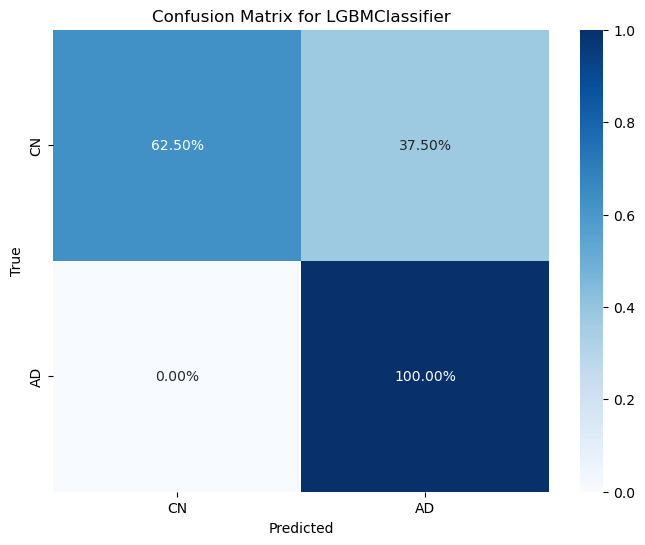

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import lightgbm as lgb # light XGBoost package

def plot_confusion_matrix(clf, X_test, y_test, class_names):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert counts to percentage
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Larger figure size for better readability
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.title(f'Confusion Matrix for {type(clf).__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

# Example usage with class names
class_names = ['CN', 'AD']  # Ensure class names are in the order of your actual labels
plot_confusion_matrix(lgb.LGBMClassifier(verbosity=-1).fit(X_train, y_train), X_test, y_test, class_names)

In [20]:
####### Default LGBM ########
model = lgb.LGBMClassifier(
    verbosity=-1,
    random_state=69
)


model.fit(X_train, y_train)

print(f'Default LGBM\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default LGBM\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned LGBM #######

params = {
    'application': 'binary', # for binary classification
#     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'binary_error',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

# Initiate classifier to use
tuned_model = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'],
          verbosity=-1)

tuned_model.fit(X_train, y_train)

print(f'Tuned LGBM\'s accuracy on training set is {100*tuned_model.score(X_train, y_train):.2f}%')
print(f'Tuned LGBM\'s accuracy on test set is {100*tuned_model.score(X_test, y_test):.2f}%')

Default LGBM's accuracy on training set is 100.00%
Default LGBM's accuracy on test set is 82.35%

Tuned LGBM's accuracy on training set is 100.00%
Tuned LGBM's accuracy on test set is 64.71%


In [22]:
from sklearn.model_selection import GridSearchCV

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(model, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 3456 candidates, totalling 13824 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 16, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.7}
0.6515151515151515


In [23]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate'] 
params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

In [24]:
# Initiate classifier to use
grid_model = lgb.LGBMClassifier(boosting_type= 'dart', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'],
          verbosity=-1)

grid_model.fit(X_train, y_train)

print(f'Tuned LGBM\'s accuracy on training set is {100*grid_model.score(X_train, y_train):.2f}%')
print(f'Tuned LGBM\'s accuracy on test set is {100*grid_model.score(X_test, y_test):.2f}%')

Tuned LGBM's accuracy on training set is 100.00%
Tuned LGBM's accuracy on test set is 82.35%


## Random Forest Grid Search

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the model and parameter grid
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

# Setup GridSearchCV
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

# Print best parameters
best_params = CV_rfc.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}


## XGBoost Grid Search

In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the XGBoost model
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

# Setup GridSearchCV
CV_xgb = GridSearchCV(estimator=xgboost_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=1)
CV_xgb.fit(X_train, y_train)

# Print best parameters
best_params_xgb = CV_xgb.best_params_
print("Best parameters for XGBoost:", best_params_xgb)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for XGBoost: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [6]:
import os

HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
save_dir = os.path.join(HOME_DIRECTORY, 'data/processed/eGeMAPS/16000')
SPLIT_DATA_DIR = save_dir

def load_dataset(filename):
    path = os.path.join(SPLIT_DATA_DIR, filename)
    if os.path.exists(path):
        return np.load(path, allow_pickle=True)
    else:
        print(f"File {filename} not found in {SPLIT_DATA_DIR}. Please check the directory and try again.")
        return None

# Loading each dataset
X_train = load_dataset('X_train.npy')
X_valid = load_dataset('X_valid.npy')
X_test = load_dataset('X_test.npy')
y_train = load_dataset('y_train.npy')
y_valid = load_dataset('y_valid.npy')
y_test = load_dataset('y_test.npy')

if X_train is not None and y_train is not None:
    print(f"Loaded X_train: {X_train.shape}, y_train: {y_train.shape}")
if X_valid is not None and y_valid is not None:
    print(f"Loaded X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
if X_test is not None and y_test is not None:
    print(f"Loaded X_test: {X_test.shape}, y_test: {y_test.shape}")

Loaded X_train: (132, 88), y_train: (132,)
Loaded X_valid: (17, 88), y_valid: (17,)
Loaded X_test: (17, 88), y_test: (17,)


In [26]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Best parameters found from grid search
best_params_rf = {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}
best_params_xgb = {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
best_params_lgb = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.64,
    'learning_rate': 0.01,
    'max_bin': 200,  # Reduced from 255
    'n_estimators': 16,
    'num_leaves': 20,  # Increased from 6
    'objective': 'binary',
    'random_state': 500,
    'reg_alpha': 0.5,  # Reduced
    'reg_lambda': 1.0,  # Reduced
    'subsample': 0.7
}


models = {
    "Random Forest": RandomForestClassifier(**best_params_rf),
    "XGBoost": xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(**best_params_lgb)
}

In [27]:
from sklearn.metrics import accuracy_score

model_outputs = {}
model_accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    model_outputs[name] = (probs, preds)
    model_accuracies[name] = accuracy
    print(f"{name} Model Accuracy: {accuracy:.4f}")

print("All models trained and predictions stored.")

Random Forest Model Accuracy: 0.8235
XGBoost Model Accuracy: 0.8824
[LightGBM] [Info] Number of positive: 69, number of negative: 63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3974
[LightGBM] [Info] Number of data points in the train set: 132, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.522727 -> initscore=0.090972
[LightGBM] [Info] Start training from score 0.090972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
import pandas as pd

def get_roc_curve(y_test, probs, model_name, color):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, linestyle='-', color=color, label=f'{model_name}', linewidth=0.7)
    plt.xlabel('False Positive Rate', fontsize=8)
    plt.ylabel('True Positive Rate', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='lower right', fontsize=8)


def get_confusion_matrix(y_test, y_pred, class_names, model_name):
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
    
    fig, ax = plt.subplots(figsize=(8, 6)) 
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def get_performance_metrics(y_test, model_outputs):
    metrics = {
        'Model': [],
        'Accuracy (%)': [],
        'Precision (%)': [],
        'Recall (%)': [],
        'F1-score (%)': []
    }

    for name, outputs in model_outputs.items():
        y_pred = outputs[1]
        metrics['Model'].append(name)
        metrics['Accuracy (%)'].append(100 * accuracy_score(y_test, y_pred))
        metrics['Precision (%)'].append(100 * precision_score(y_test, y_pred, average="macro"))
        metrics['Recall (%)'].append(100 * recall_score(y_test, y_pred, average="macro"))
        metrics['F1-score (%)'].append(100 * f1_score(y_test, y_pred, average="macro"))

    results_df = pd.DataFrame(metrics)
    return results_df

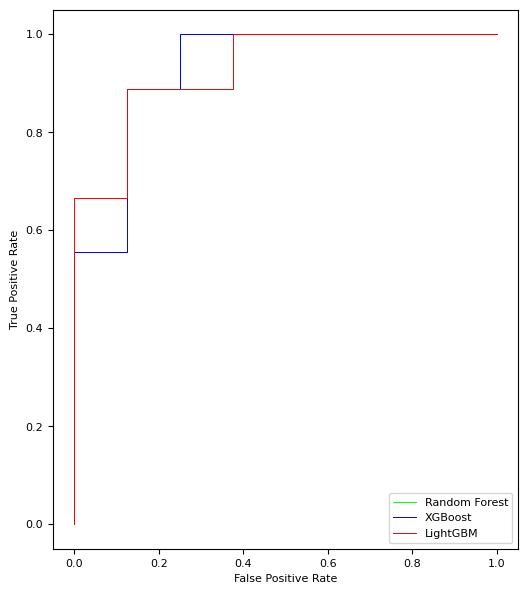

In [53]:
plt.figure(figsize=(6, 7))
colors = {'Random Forest': '#00FF00', 'XGBoost': '#0000FF', 'LightGBM': '#FF0000'}

for name, outputs in model_outputs.items():
    get_roc_curve(y_test, outputs[0], name, colors[name])

plt.show()

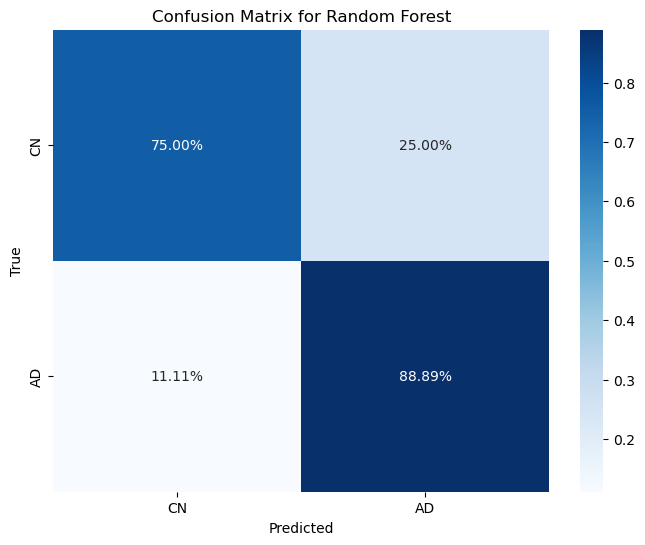

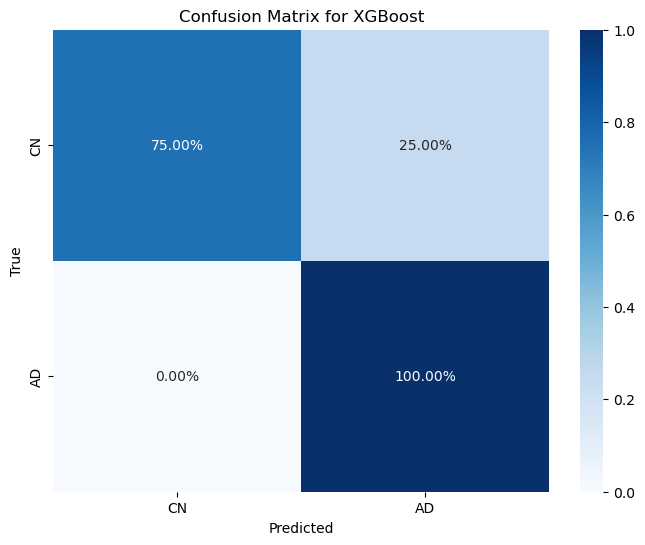

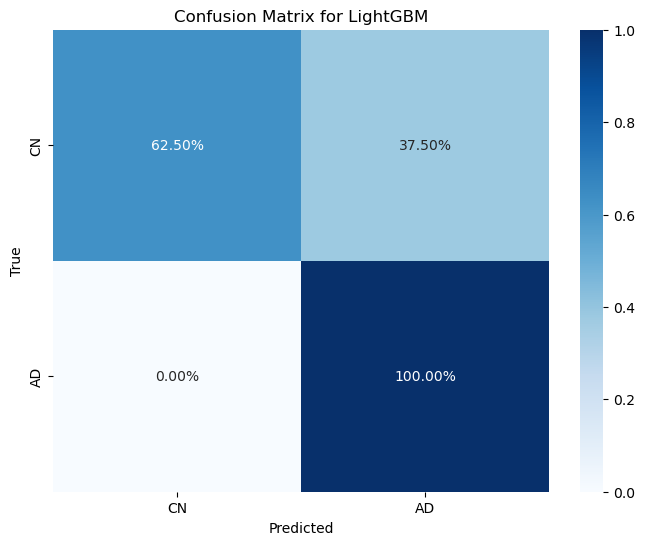

In [55]:
class_names = ['CN', 'AD']

for name, outputs in model_outputs.items():
    get_confusion_matrix(y_test, outputs[1], class_names, name)

In [56]:
results_df = get_performance_metrics(y_test, model_outputs)
print(results_df)

           Model  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)
0  Random Forest     82.352941      82.857143   81.944444     82.105263
1        XGBoost     88.235294      90.909091   87.500000     87.857143
2       LightGBM     82.352941      87.500000   81.250000     81.318681
